In [1]:
import os
import obspy 
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from obspy.core.inventory import Inventory, Network, Station, Channel, Site 
from obspy.core.inventory.util import Equipment
from obspy.clients.nrl import NRL 
from obspy import UTCDateTime
from obspy import read, read_inventory
from obspy.signal.invsim import cosine_taper 
from obspy.signal import cross_correlation
from concurrent.futures import ThreadPoolExecutor

In [2]:
def calculate_baz_horiz(st_rot, overlap, fmin, periods_per_window, st_acc=0, filen='0'):
    """
    Function to calculate baz from horizontal location, ambiguity of 180 degree.
    author: Shihao Yuan: Yuan et al. 2020, BSSA
    modified: Eva Eibl
    working: checked by Eva Eibl 9/2/2021
    TODO: remove amplitude and xcorr thresholds, add linearity as better measure for quality of BAZ

    :type st_rot: stream object
    :param st_rot: 3 component rotation rate data labelled HJ1, HJ2, HJ3 or HJE, HJN, HJZ (unit rad/s)
    :type overlap: integer
    :param overlap: overlap in seconds
    :type fmin: integer
    :param fmin: minimum frequency in Hz
    :type periods_per_window: integer
    :param periods_per_window: number of periods per window
    :type st_acc: stream object
    :param st_acc: 3 component acceleration data (seismometer) (unit m/s2)
    :type filen: string
    :param filen: path to save file

    return time vector, baz vector
    """
    t_range = int(len(st_rot[0].data)/st_rot[0].stats.sampling_rate)
    winlen = 1/fmin * periods_per_window
    dt = st_rot[0].stats.delta
    num_win = int(t_range/winlen*(1/overlap)) + 1  # number of time windows
    baz_cal = []
    t = []
    xcorrval = []
    linearity = []

    if st_acc!=0:
        # get st_rot & st_acc to have same start and endtime
        if st_acc[0].stats.endtime > st_rot[0].stats.endtime:
            end2 = st_rot[0].stats.endtime
        else:
            end2 = st_acc[0].stats.endtime
        #end
        if st_acc[0].stats.starttime > st_rot[0].stats.starttime:
            start2 = st_acc[0].stats.starttime
        else:
            start2 = st_rot[0].stats.starttime
        #end
        st_acc.trim(start2, end2)
        st_rot.trim(start2, end2)
    #end

    if st_rot[0].stats.channel=='HJ1':
       st_rot[0].stats.channel = 'HJE'
    if st_rot[1].stats.channel=='HJ2':
       st_rot[1].stats.channel = 'HJN'
    if st_rot[2].stats.channel=='HJ3':
       st_rot[2].stats.channel = 'HJZ'

    for step in np.linspace(0, t_range, num_win): #0, 60,..., 86280
        # Define time window in s and samples 
        t1 = 0 + step       # s               0   60
        t2 = t1 + winlen    # s               60  120
        t3 = int(t1/dt)  # samples         0   12000
        t4 = int(t2/dt)  # samples     12000   24000

        # zero data initialization & time window extraction
        data = (np.zeros((t4-t3, 2)))
        if len(data[:, 0])==len(st_rot.select(channel="HJE")[0].data[t3:t4]):
            data[:, 0] = st_rot.select(channel="HJE")[0].data[t3:t4] #E
            data[:, 1] = st_rot.select(channel="HJN")[0].data[t3:t4] #N

            # calculate absolute of data, not necessary 
            d0 = np.abs(data[:, 0])
            d1 = np.abs(data[:, 1])

            # calculate max ampl of whole day & mean ampl of window
            amp_data = np.mean([np.max(st_rot.select(channel="HJE")[0].data), np.max(st_rot.select(channel="HJN")[0].data)])
            amp_win  = np.mean([d0, d1]) 

            # correlate normalised N & E window  &  normalise value by dividing by (summe Nampl * summe Eampl)
            coef1 = np.correlate(d1/np.max(d1), d0/np.max(d0)) / np.sqrt(((d1/np.max(d1))**2).sum() * ((d0/np.max(d0))**2).sum())
            # ampl in window needs to be large enough & correlation high enough
            #if ( amp_win > amplthres*amp_data and coef1 > corrthres):  # Etna above 0.5
            # -- Polarization using SVD --
            # calculate covariance matrix
            if(1): # Eva & Shihao from 2019 - working
                C = np.cov(data, rowvar=False)
                # calculate eigenvalues (Cprime) and eigenvectors (Q)
                eigenval, eigenvec = np.linalg.eigh(C, UPLO='U')
                # sort eigenvector according to eigenvalues in ascending order
                loc = np.argsort(np.abs(eigenval))
                eigenval = eigenval[loc]
                eigenvec = eigenvec[:, loc]
                # calculate baz using eigenvector of smallest eigenvalue
                #baz_tmp = np.arctan(np.abs(eigenvec[1, 0]/eigenvec[0, 0])) * 180 / np.pi # shihao  only 0-90 deg
                #baz_tmp = baz_tmp + 270                                                  # shihao
                baz_tmp = np.arctan2(eigenvec[1, 0], eigenvec[0, 0])/np.pi*180.           # eva
                baz_tmp = 90 - baz_tmp            # eva  convert math angle to baz

                if baz_tmp<0:
                    baz_tmp = baz_tmp+360
                #end
            #end

            ## -- calculate Geradlinigkeit --
            eigw_mid = np.min(eigenval)
            eigw_max = np.max(eigenval)
            Flin = 1-np.sqrt(eigw_mid/eigw_max)

            # To remove the $180^\circ$ ambiguity, 
            # we then compare the rotated transverse component of rotation to 
            # the negative vertical component of acceleration (i.e. Az*(-1)) 
            # If the correlation coefficient is negtive, 180 degree will be added to baz_tmp.
            if st_acc!=0:
                if(len(st_acc[2].data[t3:t4])==len(data[:, 1])):
                    cc = correlate(-st_acc[2].data[t3:t4], 
                            rotate_ne_rt(data[:, 1], data[:, 0], baz_tmp)[1][:], shift=0)  #E 
                    shift, mcor = xcorr_max(cc)
                    if (np.sign(mcor) < 0):
                        baz_tmp = 180 +  baz_tmp 
                    #end
                #end
            #end
            if baz_tmp>360:
                baz_tmp = baz_tmp-360
            #end

            baz_cal.append(baz_tmp)
            t.append(t1+winlen/2.)
            xcorrval.append(coef1)
            linearity.append(Flin)
        #end
    #end
    
    baz_cal = np.array(baz_cal)
    t = np.array(t)
    linearity = np.array(linearity)

    if(filen != '0'):  ## -- save BAZ for horizontal location in file -- 
        tstart = st_rot[0].stats.starttime
        filename = f'{filen}.csv'
        exists = False
        if os.path.exists(filename):
            exists = True
        with open(filename, 'a+') as resfile:
            if not exists:
                resfile.write('Date,Baz,xcorrval,linearity\n')
            for i in range(len(t)):
                twindow = tstart + t[i]
                resfile.write(str(pd.Timestamp(twindow.year, twindow.month, twindow.day, twindow.hour, twindow.minute, twindow.second))+ ',' +str(baz_cal[i])+ ','+str(xcorrval[i][0])+','+str(linearity[i])+'\n')
            #end
    #end

    return baz_cal, t, xcorrval, winlen, linearity

<>:43: SyntaxWarning: invalid escape sequence '\e'
<>:54: SyntaxWarning: invalid escape sequence '\e'
<>:64: SyntaxWarning: invalid escape sequence '\c'
<>:43: SyntaxWarning: invalid escape sequence '\e'
<>:54: SyntaxWarning: invalid escape sequence '\e'
<>:64: SyntaxWarning: invalid escape sequence '\c'
C:\Users\User\AppData\Local\Temp\ipykernel_2320\4230520410.py:43: SyntaxWarning: invalid escape sequence '\e'
  ax.set_ylabel('Rotation rate E \n ($\eta$rad/s)')
C:\Users\User\AppData\Local\Temp\ipykernel_2320\4230520410.py:54: SyntaxWarning: invalid escape sequence '\e'
  ax0.set_ylabel('Rotation rate N \n ($\eta$rad/s)')
C:\Users\User\AppData\Local\Temp\ipykernel_2320\4230520410.py:64: SyntaxWarning: invalid escape sequence '\c'
  ax1.set_ylabel('Back azimuth ($^\circ$)')


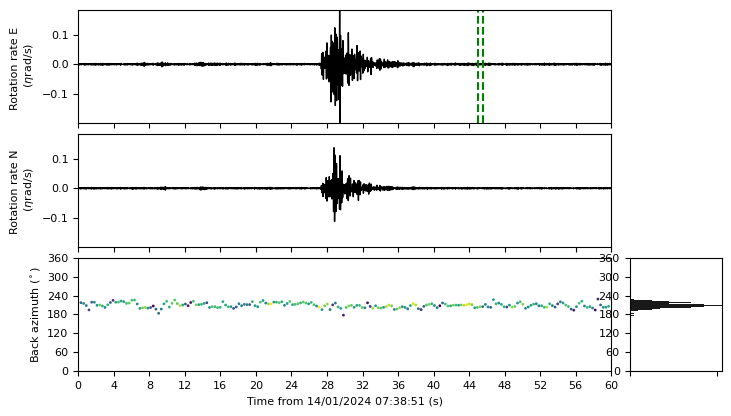

In [3]:
# Define the day and read the data
day = '014'
st1 = read(f"../DATA/HJ1.D/XX.XB102.00.HJ1.D.2024.{day}")
st2 = read(f"../DATA/HJ2.D/XX.XB102.00.HJ2.D.2024.{day}")
st3 = read(f"../DATA/HJ3.D/XX.XB102.00.HJ3.D.2024.{day}")
st_rot = st1 + st2 + st3 

# Define properties to read in data
periods_per_window = 3
fmin = 5
fmax = 15
tstart = UTCDateTime(2024, 1, 14, 7, 38, 51)
tend = UTCDateTime(2024, 1, 14, 7, 39, 51)
wlen = tend - tstart
tend_late = tend + 60
tstart_early = tstart - 60

# Pre-process the data
st_rot.merge(method=1, fill_value='interpolate')
st_rot.normalize()
st_rot.trim(tstart_early, tend_late)
st_rot.detrend('demean')
st_rot.detrend('linear')
st_rot.taper(0.01)
st_rot.filter("bandpass", freqmin=fmin, freqmax=fmax)
st_rot.trim(tstart, tend)

if len(st_rot) > 0:
    # Convert data units to rad/s
    for i in range(3):
        st_rot[i].data = st_rot[i].data * 1e-9

    overlap = 0.5
    baz_cal, t, xcorr, win, lin = calculate_baz_horiz(st_rot, overlap, fmin, periods_per_window, 0)

    # Plot rotation E, rotation N, baz for EQ
    fig = plt.figure(figsize=(7.48, 4))
    matplotlib.rcParams.update({'font.size': 8})
    
    # Plot rotation E
    ax = plt.subplot2grid((3, 6), (0, 0), colspan=5)
    ax.plot(st_rot[0].data * 1e9, 'k', lw=1)
    ax.set_ylabel('Rotation rate E \n ($\eta$rad/s)')
    ax.set_xticks(np.arange(0, wlen * st_rot[1].stats.sampling_rate + wlen, st_rot[2].stats.sampling_rate * 4))
    ax.set_xlim(0, wlen * st_rot[1].stats.sampling_rate)
    ax.axvline(0.75 * wlen * st_rot[1].stats.sampling_rate, ls="--", color="g")
    ax.axvline(0.75 * wlen * st_rot[1].stats.sampling_rate + win * st_rot[1].stats.sampling_rate, ls="--", color="g")
    ax.set_ylim(st_rot[0].data.min() * 10**9,st_rot[0].data.max() * 10**9)
    plt.setp(ax.get_xticklabels(), visible=False)

    # Plot rotation N
    ax0 = plt.subplot2grid((3, 6), (1, 0), colspan=5)
    ax0.plot(st_rot[1].data * 1e9, 'k', lw=1)
    ax0.set_ylabel('Rotation rate N \n ($\eta$rad/s)')
    ax0.set_xticks(np.arange(0, wlen * st_rot[1].stats.sampling_rate + wlen, st_rot[2].stats.sampling_rate * 4))
    ax0.set_xlim(0, wlen * st_rot[1].stats.sampling_rate)
    ax0.set_ylim(st_rot[0].data.min() * 10**9, st_rot[0].data.max() * 10**9)
    plt.setp(ax0.get_xticklabels(), visible=False)

    # Plot baz
    ax1 = plt.subplot2grid((3, 6), (2, 0), colspan=5)
    ax1.scatter(t, baz_cal, c=xcorr, s=1, label='Estimated Baz using Re and Rn')
    ax1.set_xlabel(f'Time from {tstart.day:02}/{tstart.month:02}/2024 {tstart.hour:02}:{tstart.minute:02}:{tstart.second:02} (s)')
    ax1.set_ylabel('Back azimuth ($^\circ$)')
    ax1.set_ylim(0, 360)
    ax1.set_xticks(np.arange(0, 62, 4))  # every 4 seconds
    ax1.set_yticks(np.arange(0, 420, 60))
    ax1.set_xlim(0, wlen)

    # Plot baz histogram
    n, bins, patches = plt.hist(baz_cal, np.arange(0, 360, 2), facecolor='k', alpha=0.00001, orientation='horizontal')
    Az_dom = ((bins[np.argmax(n)] + bins[np.argmax(n) + 1]) / 2.)

    ax2 = plt.subplot2grid((3, 6), (2, 5))
    ax2.hist(baz_cal, np.arange(0, 360, 2), facecolor='k', alpha=0.9, orientation='horizontal')
    ax2.xaxis.set_ticklabels([])
    ax2.set_xlim(np.min(n), np.max(n))
    ax2.set_yticks(np.arange(0, 420, 60))
    ax2.set_ylim(0, 360)

    # Adjust and save
    plt.subplots_adjust(top=0.99, bottom=0.088, left=0.12, right=0.98, hspace=0.1)
    plt.show()

    fig.savefig("../figures/bAz_014_typeB.png")